In [212]:
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score

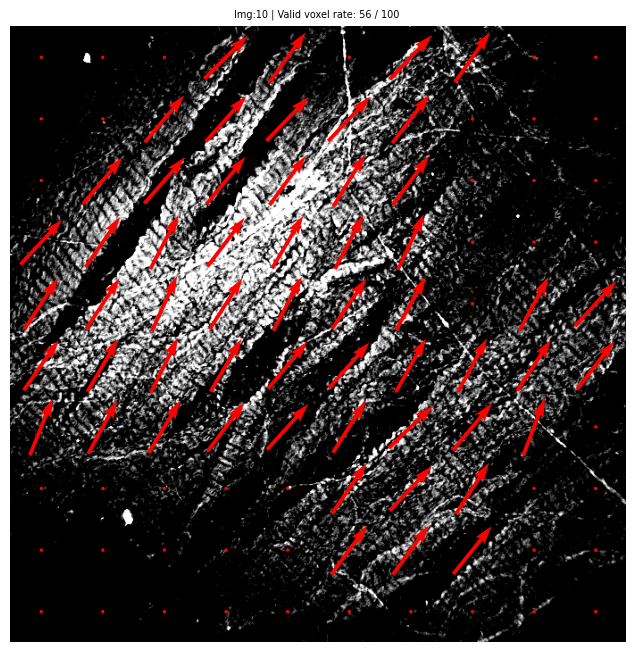

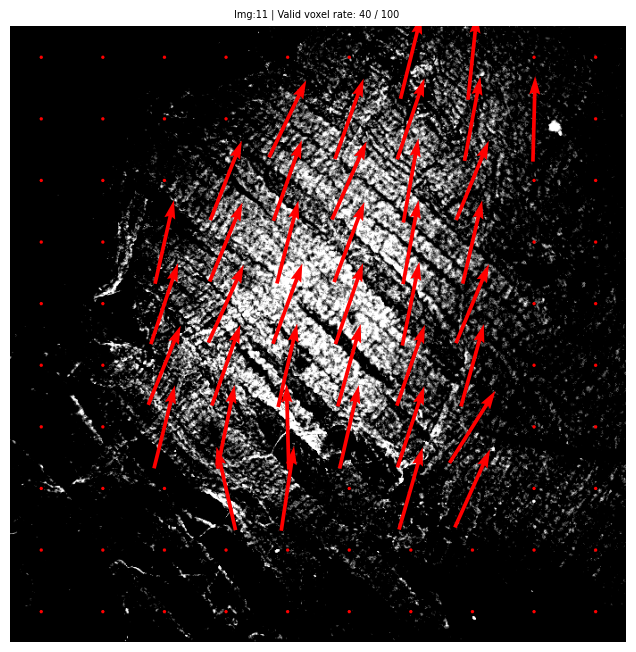

In [213]:
with open('model.pkl', 'rb') as f:
    model= pickle.load(f)

def get_feature_vector(image, grid_q= 4, no_orientation= 8):
    if type(grid_q)== np.ndarray: # ndarray path
        hog_features= []
        for gq in grid_q:
            hf= get_feature_vector(image, grid_q= gq, no_orientation= no_orientation)
            hog_features= np.append(hog_features, hf)
    else: # integer path
        ppc= (int(image.shape[0]/grid_q), int(image.shape[1]/grid_q))
        hog_features= hog(image, orientations= no_orientation, pixels_per_cell= (int(image.shape[0]/grid_q), int(image.shape[1]/grid_q)),
                        cells_per_block=(1, 1), feature_vector= True)
    return hog_features

def slice_image(image_path, voxel_size):
    image= Image.open(image_path)
    image= image.convert('L')
    image_width, image_height = image.size
    sliced_list= []
    pos_list= np.empty((0, 2))

    for y in range(0, image_height-voxel_size+1, voxel_size):
        for x in range(0, image_width-voxel_size+1, voxel_size):
            box = (x, y, x + voxel_size, y + voxel_size)
            voxel = image.crop(box)
            sliced_list.append(voxel)
            pos_list= np.append(pos_list, [x, y])

    return sliced_list, pos_list.reshape((-1, 2))

def check_image(image):
    img= np.array(image)
    valid= True

    if np.mean(img) < .05*256 or np.mean(img) > .95*256:
        valid= False
    return valid

GRIDQ= np.arange(1, 6)
VOXEL_SIZE= 69
file_dir= "./pictures/por_image/"
file_list= [file for file in os.listdir(file_dir) if file.endswith(".png")]
file_list= ["10.png", "11.png"]
# file_list= ["hak.png"]

for img_name in file_list:
    img_dir= file_dir + img_name
    voxel_list, pos_list= slice_image(img_dir, VOXEL_SIZE)
    angle_list= []
    x= pos_list[:, 0] + VOXEL_SIZE/2
    y= pos_list[:, 1] + VOXEL_SIZE/2
    u= []
    v= []
    w= 0.01 * VOXEL_SIZE
    valid_count, invalid_count= 0, 0
    for voxel in voxel_list:
        if check_image(voxel):
            feature_vector= get_feature_vector(np.array(voxel), GRIDQ)
            angle= float(model.predict(feature_vector.reshape(1, -1))) * (np.pi/180)
            angle_list.append(angle)
            u.append(w*np.cos(angle))
            v.append(w*np.sin(angle))
            
            valid_count += 1
        else:
            angle_list.append(None)
            u.append(0)
            v.append(0)
            invalid_count += 1

    plt.figure(figsize= (8, 8))
    plt.imshow(Image.open(img_dir).convert("L"), cmap= "gray")
    plt.quiver(x, y, u, v, color= "red", pivot= "middle")
    
    plt.axis("off")
    plt.title(f"Img:{img_name[:2]} | Valid voxel rate: {valid_count} / {valid_count+invalid_count} ", fontsize= 7)


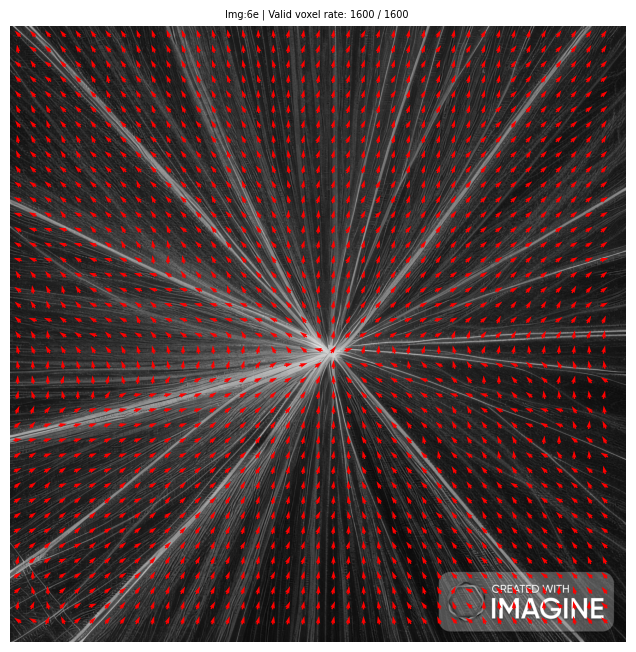

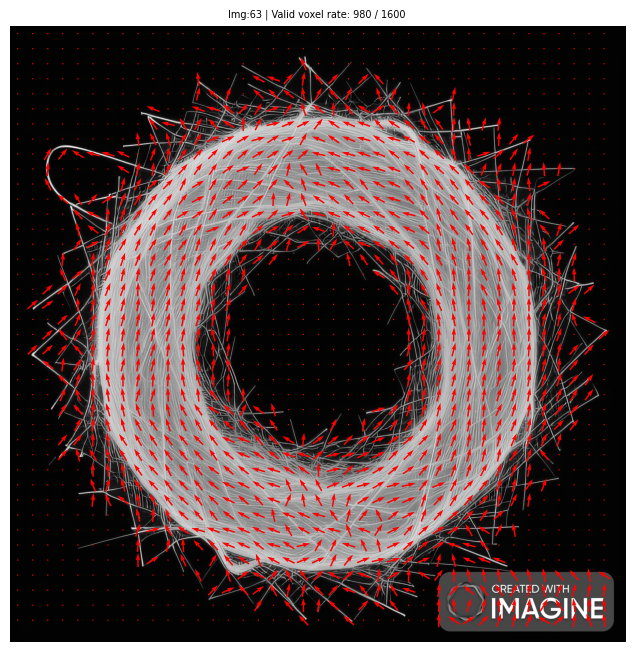

In [214]:
VOXEL_SIZE= 50
file_dir= "./diffusion/Big/"
file_list= ["6e2d5fca-bd10-412b-85e7-c46a555aeb72_upscaled.png", "63913bb5-e453-46b6-8ffb-0e3aa8b1efc8_upscaled.png"]

for img_name in file_list:
    img_dir= file_dir + img_name
    voxel_list, pos_list= slice_image(img_dir, VOXEL_SIZE)
    angle_list= []
    x= pos_list[:, 0] + VOXEL_SIZE/2
    y= pos_list[:, 1] + VOXEL_SIZE/2
    u= []
    v= []
    w= 0.01 * VOXEL_SIZE
    valid_count, invalid_count= 0, 0
    for voxel in voxel_list:
        if check_image(voxel):
            feature_vector= get_feature_vector(np.array(voxel), GRIDQ)
            angle= float(model.predict(feature_vector.reshape(1, -1))) * (np.pi/180)
            angle_list.append(angle)
            u.append(w*np.cos(angle))
            v.append(w*np.sin(angle))
            
            valid_count += 1
        else:
            angle_list.append(None)
            u.append(0)
            v.append(0)
            invalid_count += 1

    plt.figure(figsize= (8, 8))
    plt.imshow(Image.open(img_dir).convert("L"), cmap= "gray")
    plt.quiver(x, y, u, v, color= "red", pivot= "middle")
    
    plt.axis("off")
    plt.title(f"Img:{img_name[:2]} | Valid voxel rate: {valid_count} / {valid_count+invalid_count} ", fontsize= 7)
